In [59]:
import numpy as np
from scipy.sparse import diags, csr_matrix ,tril
from scipy.sparse.linalg import cg, spilu, LinearOperator

In [60]:
# Function to create matrix A
def create_matrix_A(n):
    diagonals = [
        -1 * np.ones(n - 1),  # Lower diagonal
        2 * np.ones(n),       # Main diagonal
        -1 * np.ones(n - 1)   # Upper diagonal
    ]
    
    # Create the sparse matrix
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')
    
    # Adjust the last diagonal element
    A[-1, -1] = 1  # Update the last diagonal element directly in the sparse matrix
    
    return A

n = 1000  # Size of the matrix
A = create_matrix_A(n)

# Right-hand side vector b
b = np.zeros(n)
b[0] = 1  # As per problem definition


In [61]:
def ichol_sparse_optimized(A): #final version
    """
    Optimized Incomplete Cholesky factorization for a sparse matrix A.
    A should be a symmetric positive definite matrix in CSR format.
    """
    A = A.tocsr()  # Ensure A is in CSR format
    n = A.shape[0]
    L = A.copy()   # Create a copy of A to store the result

    for k in range(n):
        # Update the diagonal element
        L[k, k] = np.sqrt(L[k, k])
        
        # Update column k below the diagonal
        rows = L.indices[L.indptr[k] : L.indptr[k + 1]]
        rows = rows[rows > k]  # Only consider rows below the diagonal
        
        if rows.size > 0:
            L[rows, k] /= L[k, k]

        # Update the lower-right submatrix
        for i in rows:
            L[i, rows] -= L[i, k] * L[rows, k]
    
    # Extract the lower triangular part of L
    L = tril(L, format='csr')
    return L


In [55]:
n = 1000  # Size of the matrix
A = create_matrix_A(n)

In [57]:
# Compute the Incomplete Cholesky factorization
L_optimised = ichol_sparse_optimized(A)

# # Print the sparsity structure of L
# print("Sparsity of L:", L.nnz / (n * n))

In [58]:
from scipy.sparse.linalg import spilu, LinearOperator

# Compute the Incomplete Cholesky factorization using scipy's spilu
A_csc = A.tocsc()  # Convert A to CSC format as required by spilu
ilu = spilu(A_csc, drop_tol=1e-4, fill_factor=10)

# Extract the lower triangular matrix L from spilu
L_spilu = ilu.L.todense()

# Compute the Frobenius norm of the difference between the two matrices
difference_norm = np.linalg.norm(L.toarray() - L_spilu, ord='fro')

# # Print the matrices and the norm of the difference
# print("Manually Computed Incomplete Cholesky Factorization (L):")
# print(L.toarray())

# print("\nscipy's spilu Incomplete Cholesky Factorization (L):")
# print(L_spilu)

print(f"\nFrobenius Norm of the Difference: {difference_norm}")

# Verify properties: L * L^T should approximate A
A_manual_reconstructed = L @ L.T
A_manual_optimised = L_optimised @ L_optimised.T
A_spilu_reconstructed = np.dot(L_spilu, L_spilu.T)

# Check the norm of the difference between A and the reconstructed matrices
manual_diff = np.linalg.norm(A.toarray() - A_manual_reconstructed, ord='fro')
manual_diff_optimised = np.linalg.norm(A.toarray() - A_manual_optimised, ord='fro')
spilu_diff = np.linalg.norm(A.toarray() - A_spilu_reconstructed, ord='fro')

print(f"\nReconstruction Error (Manual): {manual_diff}")
print(f"\nReconstruction Error (optimised): {manual_diff_optimised}")
print(f"Reconstruction Error (spilu): {spilu_diff}")



Frobenius Norm of the Difference: 1.96904364855533

Reconstruction Error (Manual): 5.133506074316015e-15

Reconstruction Error (optimised): 5.133506074316015e-15
Reconstruction Error (spilu): 3.4459711932638433


In [32]:
# Compute the Incomplete Cholesky factorization of A
from scipy.sparse.linalg import spilu

# Since A is symmetric positive-definite, we need to ensure it suits the ILU solver
# Convert A to CSC format for spilu
A_csc = A.tocsc()

# Set drop tolerance and fill factor for the ILU (used as IC in symmetric cases)
ilu = spilu(A_csc, drop_tol=1e-4, fill_factor=10)

# Create a LinearOperator for the preconditioner
M_x = lambda x: ilu.solve(x)
M = LinearOperator(A.shape, M_x)


In [33]:
print(M)

<10x10 _CustomLinearOperator with dtype=float64>


Note: While spilu is designed for general matrices, it can be used to approximate the Incomplete Cholesky factorization for symmetric positive-definite matrices by treating it as an incomplete LU factorization. Alternatively, you can use scipy.sparse.linalg.spilu with appropriate options to mimic incomplete Cholesky.

In [4]:
# Initial guess
x0 = np.zeros_like(b)


In [5]:

# Solve using CG with the preconditioner
x, info = cg(A, b, x0=x0, atol=1e-6, maxiter=n, M=M)

if info == 0:
    print("Converged successfully with preconditioning.")
else:
    print(f"CG did not converge within the maximum number of iterations. Info code: {info}")


Converged successfully with preconditioning.


In [6]:
# Solve without preconditioning
x_np, info_np = cg(A, b, x0=x0, atol=1e-6, maxiter=n)

if info_np == 0:
    print("Converged successfully without preconditioning.")
else:
    print(f"CG did not converge within the maximum number of iterations without preconditioning. Info code: {info_np}")


CG did not converge within the maximum number of iterations without preconditioning. Info code: 1000


In [7]:
# Callback function to record residual norms
def callback_pre(xk):
    residual_norms_pre.append(np.linalg.norm(b - A @ xk))

def callback_np(xk):
    residual_norms_np.append(np.linalg.norm(b - A @ xk))

# Lists to store residual norms
residual_norms_pre = []
residual_norms_np = []

# Solve with preconditioning
x, info = cg(A, b, x0=x0, atol=1e-6, M=M, maxiter=n,callback=callback_pre)

# Solve without preconditioning
x_np, info_np = cg(A, b, x0=x0, atol=1e-6,maxiter=n, callback=callback_np)

# Number of iterations
iterations_pre = len(residual_norms_pre)
iterations_np = len(residual_norms_np)

print(f"CG with preconditioning converged in {iterations_pre} iterations.")
print(f"CG without preconditioning converged in {iterations_np} iterations.")


CG with preconditioning converged in 1 iterations.
CG without preconditioning converged in 1000 iterations.


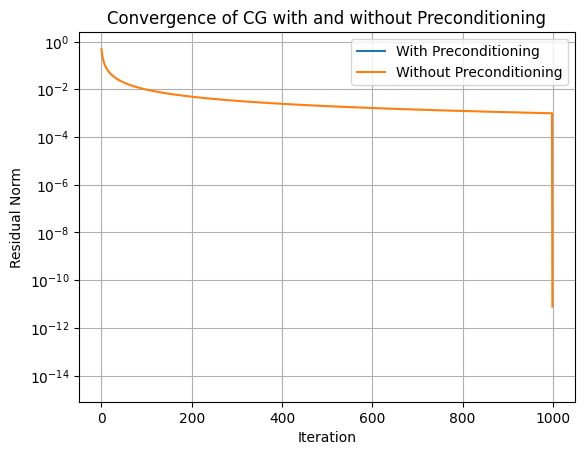

In [8]:
import matplotlib.pyplot as plt

plt.semilogy(range(iterations_pre), residual_norms_pre, label='With Preconditioning')
plt.semilogy(range(iterations_np), residual_norms_np, label='Without Preconditioning')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence of CG with and without Preconditioning')
plt.legend()
plt.grid(True)
plt.show()
